# Fama French
- Code source: [Freda Song Drechsler](https://www.fredasongdrechsler.com/full-python-code/fama-french)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import wrds
import os
pd.set_option('display.max_columns', 200)


In [2]:
conn=wrds.Connection()

Enter your WRDS username [brandongoldney]:acassidy
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


## Compustat

In [3]:
# # Compustat
# comp = conn.raw_sql("""
#                     select gvkey, datadate, at, pstkl, txditc,
#                     pstkrv, seq, pstk
#                     from comp.funda
#                     where indfmt='INDL' 
#                     and datafmt='STD'
#                     and popsrc='D'
#                     and consol='C'
#                     and datadate >='01/01/1959'
#                     """, date_cols=['datadate'])
#comp.to_csv('../data/wrds_comp_funda.csv')
comp = pd.read_csv('../data/wrds_comp_funda.csv',infer_datetime_format= True, parse_dates=['datadate'] )

comp['year'] = comp['datadate'].dt.year

# create preferrerd stock
# PSTKL -- Preferred Stock Liquidating Value is recorded in millions
# PSTKRV -- Preferred Stock Redemption Value is recorded in millions
# TXDITC -- Deferred Taxes and Investment Tax Credit is recorded in millions
comp['ps'] = np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps'] = np.where(comp['ps'].isnull(), comp['pstk'], comp['ps'])
comp['ps'] = np.where(comp['ps'].isnull(), 0,comp['ps'])
comp['txditc'] = comp['txditc'].fillna(0)

# create book equity
# SEQ -- Stockholders' Equity - Total is recorded in millions
comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']

# Filter out negative book equity firms. "We do not use negative BE firms, which are rare prior to 1980, when calculating
# the breakpoints for BE/ME or when forming the size-BE/ME portfolios" - source: 
# (Multifactor Explanations of Asset Pricing Anomalies)
comp['be'] = np.where(comp['be']>0, comp['be'], np.nan)

# number of years in Compustat
comp = comp.sort_values(by = ['gvkey','datadate'])
comp['count'] = comp.groupby(['gvkey']).cumcount()

comp = comp[['gvkey','datadate','year','be','count']]
comp.head()

,gvkey,datadate,year,be,count
0,1000,1961-12-31,1961,NaN,0
1,1000,1962-12-31,1962,NaN,1
2,1000,1963-12-31,1963,0.561,2
3,1000,1964-12-31,1964,0.627,3
4,1000,1965-12-31,1965,0.491,4


## CRSP

In [4]:
# # CRSP Block   
# # sql similar to crspmerge macro
# crsp_m = conn.raw_sql("""
#                       select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
#                       a.ret, a.retx, a.shrout, a.prc
#                       from crsp.msf as a
#                       left join crsp.msenames as b
#                       on a.permno=b.permno
#                       and b.namedt<=a.date
#                       and a.date<=b.nameendt
#                       where a.date between '01/01/1959' and '12/31/2017'
#                       and b.exchcd between 1 and 3
#                       """, date_cols=['date']) 
# crsp_m.to_csv('../data/wrds_crsp_msenames.csv')
crsp_m = pd.read_csv('../data/wrds_crsp_msenames.csv', infer_datetime_format= True, parse_dates=['date'])
# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']] = crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['jdate'] = crsp_m['date'] + MonthEnd(0)

crsp_m.head()

,Unnamed: 0,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate
0,0,10001,7953,1994-07-29,11,3,0.072464,0.072464,2191.0,9.2500,1994-07-31
1,1,10001,7953,1987-11-30,11,3,-0.029412,-0.029412,992.0,6.1875,1987-11-30
2,2,10001,7953,1987-12-31,11,3,-0.033535,-0.050505,992.0,5.8750,1987-12-31
3,3,10001,7953,1988-01-29,11,3,0.063830,0.063830,992.0,6.2500,1988-01-31
4,4,10001,7953,1988-02-29,11,3,0.080000,0.080000,992.0,6.7500,1988-02-29


In [5]:
# dlret  =  conn.raw_sql("""
#                      select permno, dlret, dlstdt 
#                      from crsp.msedelist
#                      """, date_cols = ['dlstdt'])
# dlret.to_csv('../data/wrds_dlret.csv')

dlret = pd.read_csv('../data/wrds_dlret.csv', infer_datetime_format= True, parse_dates=['dlstdt'],\
                   usecols=['permno', 'dlret', 'dlstdt'])
dlret.permno = dlret.permno.astype(int)
dlret['jdate'] = dlret['dlstdt'] + MonthEnd(0)

dlret.head()

,permno,dlret,dlstdt,jdate
0,10000,0.000000,1987-06-11,1987-06-30
1,10001,0.011583,2017-08-03,2017-08-31
2,10002,0.046007,2013-02-15,2013-02-28
3,10003,0.013730,1995-12-15,1995-12-31
4,10005,0.125000,1991-07-11,1991-07-31


In [6]:
crsp = pd.merge(crsp_m, dlret, how = 'left',on = ['permno','jdate'])
crsp['dlret'] = crsp['dlret'].fillna(0)
crsp['ret'] = crsp['ret'].fillna(0)

# retadj factors in the delisting returns
crsp['retadj'] = (1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
# SHROUT is the number of publicly held shares, recorded in thousands
crsp['me'] = crsp['prc'].abs() * crsp['shrout'] 
crsp = crsp.drop(['dlret','dlstdt','prc','shrout'], axis = 1)
crsp = crsp.sort_values(by = ['jdate','permco','me'])

crsp.head()

,Unnamed: 0,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me
506752,506752,17670,74,1959-01-30,10,1,0.016667,0.006410,1959-01-31,0.016667,17034.5
542132,542132,18702,267,1959-01-30,10,1,0.149254,0.149254,1959-01-31,0.149254,28297.5
605553,605553,20714,584,1959-01-30,10,1,0.129412,0.129412,1959-01-31,0.129412,40512.0
154286,154286,11287,921,1959-01-30,10,1,0.097403,0.097403,1959-01-31,0.097403,37180.0
620682,620682,21151,994,1959-01-30,10,1,0.009009,0.009009,1959-01-31,0.009009,14826.0


In [7]:
### Aggregate Market Cap 
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp = pd.merge(crsp, crsp_maxme, how = 'inner', on = ['jdate','permco','me']).drop(['me'], axis = 1)

crsp.head()

,Unnamed: 0,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj
0,506752,17670,74,1959-01-30,10,1,0.016667,0.006410,1959-01-31,0.016667
1,542132,18702,267,1959-01-30,10,1,0.149254,0.149254,1959-01-31,0.149254
2,605553,20714,584,1959-01-30,10,1,0.129412,0.129412,1959-01-31,0.129412
3,154286,11287,921,1959-01-30,10,1,0.097403,0.097403,1959-01-31,0.097403
4,620682,21151,994,1959-01-30,10,1,0.009009,0.009009,1959-01-31,0.009009


In [8]:
# join with sum of me to get the correct market cap info
crsp = pd.merge(crsp, crsp_summe, how = 'inner', on = ['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp = crsp.sort_values(by = ['permno','jdate']).drop_duplicates()
crsp.head()

,Unnamed: 0,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me
1176179,11,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,16100.000000
1182381,12,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,11960.000000
1188592,13,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,16330.000000
1194813,14,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,15172.000000
1201044,15,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,11793.859375


In [9]:
# keep December market cap
crsp['year'] = crsp['jdate'].dt.year
crsp['month'] = crsp['jdate'].dt.month
decme = crsp[crsp['month'] == 12]
decme = decme[['permno','date','jdate','me','year']].rename(columns = {'me':'dec_me'})
decme['year'] = decme['year'] + 1
decme = decme[['permno','year','dec_me']]

### July to June dates
crsp['ffdate'] = crsp['jdate'] + MonthEnd(-6) # subtracts 6 months from current date
crsp['ffyear'] = crsp['ffdate'].dt.year
crsp['ffmonth'] = crsp['ffdate'].dt.month
crsp['1+retx'] = 1 + crsp['retx']
crsp = crsp.sort_values(by = ['permno','date'])

# cumret by stock
crsp['cumretx'] = crsp.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp['lcumretx'] = crsp.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp['lme'] = crsp.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp['count'] = crsp.groupby(['permno']).cumcount()
crsp['lme'] = np.where(crsp['count'] == 0, crsp['me'] / crsp['1+retx'], crsp['lme'])

# baseline me
mebase = crsp[crsp['ffmonth'] == 1][['permno','ffyear', 'lme']].rename(columns = {'lme':'mebase'})

# merge result back together
crsp = pd.merge(crsp, mebase, how = 'left', on = ['permno','ffyear'])
crsp['wt'] = np.where(crsp['ffmonth'] == 1, crsp['lme'], crsp['mebase']*crsp['lcumretx'])

crsp.head()

,Unnamed: 0,permno,permco,date,shrcd,exchcd,ret,retx,jdate,retadj,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,count,mebase,wt
0,11,10000,7952,1986-01-31,10,3,0.000000,NaN,1986-01-31,0.000000,16100.000000,1986,1,1985-07-31,1985,7,NaN,NaN,NaN,NaN,0,NaN,NaN
1,12,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,1986-02-28,-0.257143,11960.000000,1986,2,1985-08-31,1985,8,0.742857,0.742857,NaN,16100.0,1,NaN,NaN
2,13,10000,7952,1986-03-31,10,3,0.365385,0.365385,1986-03-31,0.365385,16330.000000,1986,3,1985-09-30,1985,9,1.365385,1.014286,0.742857,11960.0,2,NaN,NaN
3,14,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,1986-04-30,-0.098592,15172.000000,1986,4,1985-10-31,1985,10,0.901408,0.914286,1.014286,16330.0,3,NaN,NaN
4,15,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,1986-05-31,-0.222656,11793.859375,1986,5,1985-11-30,1985,11,0.777344,0.710714,0.914286,15172.0,4,NaN,NaN


In [10]:
# Info as of June
crsp_jun = crsp[crsp['month'] == 6]

crsp_jun = pd.merge(crsp_jun, decme, how = 'inner', on = ['permno','year'])
crsp_jun = crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme',\
                     'dec_me']]
crsp_jun = crsp_jun.sort_values(by = ['permno','jdate']).drop_duplicates()

crsp_jun.head()

,permno,date,jdate,shrcd,exchcd,retadj,me,wt,cumretx,mebase,lme,dec_me
0,10001,1987-06-30,1987-06-30,11,3,0.051429,5822.125,5602.187450,0.959184,6033.125,5636.3125,6937.00
1,10001,1988-06-30,1988-06-30,11,3,-0.012039,6200.000,6379.562514,1.063830,5822.125,6386.0000,5828.00
2,10001,1989-06-30,1989-06-30,11,3,0.017143,7007.000,6944.000017,1.120000,6200.000,6986.0000,6362.25
3,10001,1990-06-29,1990-06-30,11,3,0.014103,10052.250,9759.750037,1.392857,7007.000,10013.2500,10347.75
4,10001,1991-06-28,1991-06-30,11,3,0.078481,11266.500,10181.124978,1.076923,10052.250,10408.2500,10013.00


## CCM Linking Table

In [78]:
# CCM Block
# ccm=conn.raw_sql("""
#                   select gvkey, lpermno as permno, linktype, linkprim, 
#                   linkdt, linkenddt
#                   from crsp.ccmxpf_linktable
#                   where substr(linktype,1,1)='L'
#                   and (linkprim ='C' or linkprim='P')
#                   """, date_cols=['linkdt', 'linkenddt'])


ccm = pd.read_csv('../data/linking_table_crsp_compustat.csv',\
                            usecols=['gvkey', 'LPERMNO', 'LINKTYPE', 'LINKPRIM', 'LINKDT', 'LINKENDDT'],\
                           infer_datetime_format= True, parse_dates=['LINKENDDT'])

ccm.rename(columns={'LPERMNO': 'permno'}, inplace=True)

# Convert linkenddt to datetime
ccm.columns= ccm.columns.str.lower()
ccm = ccm[~ccm.linkenddt.str.contains('E')]
ccm = ccm[~ccm.linkenddt.isnull()]
ccm = ccm[~ccm.linkdt.isnull()]

# Convert columns to datetime format
ccm['linkdt'] = ccm.linkdt.astype('int32').astype('datetime64[ns]').dt.date
ccm['linkenddt'] = pd.to_datetime(ccm.linkenddt, format="%Y-%m-%d")

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))


# if linkenddt is missing then set to today date
ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.to_datetime('today'))

comp['gvkey'] = comp.gvkey.astype('int32')

comp_ccm = pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
comp_ccm['yearend'] = comp_ccm['datadate'] + YearEnd(0)
comp_ccm['jdate'] = comp_ccm['yearend'] + MonthEnd(6)

# set link date bounds
comp_ccm = comp_ccm[(comp_ccm['jdate']>=comp_ccm['linkdt'])&(comp_ccm['jdate']<=comp_ccm['linkenddt'])]
comp_ccm = comp_ccm[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# link comp and crsp
crsp_comp_jun = pd.merge(crsp_jun, comp_ccm, how='inner', on=['permno', 'jdate'])

# dec_me is December Market Equity, beme is Book Equity
crsp_comp_jun['beme'] = crsp_comp_jun['be'] * 1_000 / crsp_comp_jun['dec_me']

crsp_comp_jun.head()

,permno,date,jdate,shrcd,exchcd,retadj,me,wt,cumretx,mebase,lme,dec_me,gvkey,datadate,yearend,be,count,beme
0,10001,1987-06-30,1987-06-30,11,3,0.051429,5822.125,5602.187450,0.959184,6033.125,5636.3125,6937.00,12994,1986-06-30,1986-12-31,7.037,0,1.014415
1,10001,1988-06-30,1988-06-30,11,3,-0.012039,6200.000,6379.562514,1.063830,5822.125,6386.0000,5828.00,12994,1987-06-30,1987-12-31,7.038,1,1.207618
2,10001,1989-06-30,1989-06-30,11,3,0.017143,7007.000,6944.000017,1.120000,6200.000,6986.0000,6362.25,12994,1988-06-30,1988-12-31,7.286,2,1.145192
3,10001,1990-06-29,1990-06-30,11,3,0.014103,10052.250,9759.750037,1.392857,7007.000,10013.2500,10347.75,12994,1989-06-30,1989-12-31,8.466,3,0.818149
4,10001,1991-06-28,1991-06-30,11,3,0.078481,11266.500,10181.124978,1.076923,10052.250,10408.2500,10013.00,12994,1990-06-30,1990-12-31,9.438,4,0.942575


In [79]:
# select NYSE stocks for bucket breakdown

# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse = crsp_comp_jun[(crsp_comp_jun['exchcd']==1) & (crsp_comp_jun['beme']>0) & (crsp_comp_jun['me']>0) & \
             (crsp_comp_jun['count']>=1) & ((crsp_comp_jun['shrcd']==10) | (crsp_comp_jun['shrcd']==11))]

# size breakdown
nyse_sz = nyse.groupby(['jdate'])['me'].describe(percentiles=[0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8]).reset_index()
nyse_sz = nyse_sz[['jdate','20%', '40%', '50%', '60%', '80%']]\
            .rename(columns={'20%':'me20','40%':'me40','50%': 'sizemedn','60%':'me60','80%':'me80'})

# beme breakdown
nyse_bm = nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.2, 0.3, 0.4, 0.6, 0.7, 0.8]).reset_index()
nyse_bm = nyse_bm[['jdate','20%','30%', '40%', '60%','70%', '80%']]\
            .rename(columns={'20%':'bm20','30%':'bm30','40%':'bm40','60%':'bm60',\
                             '70%':'bm70','80%':'bm80'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

nyse_breaks.head()

,jdate,me20,me40,sizemedn,me60,me80,bm20,bm30,bm40,bm60,bm70,bm80
0,1970-06-30,29910.0,63945.00,93151.0625,134300.00,375081.000,0.380959,0.485313,0.582550,0.784086,0.914678,1.078569
1,1971-06-30,46087.5,104106.25,147004.0000,197314.20,515885.350,0.446618,0.561904,0.668790,0.871257,1.010969,1.205252
2,1972-06-30,47262.7,101262.70,142877.6250,215438.60,518890.225,0.382046,0.507576,0.625112,0.836939,0.947305,1.116257
3,1973-06-30,28903.5,64142.10,96528.2500,147052.50,397846.750,0.397069,0.519784,0.650635,0.870725,1.000058,1.173933
4,1974-06-30,23524.6,50290.50,76116.2500,115467.25,326201.500,0.699242,0.904720,1.103381,1.476210,1.722860,2.051972


In [80]:
# join back size and beme breakdown
crsp_comp_jun = pd.merge(crsp_comp_jun, nyse_breaks, how='left', on=['jdate'])
crsp_comp_jun.head()

,permno,date,jdate,shrcd,exchcd,retadj,me,wt,cumretx,mebase,lme,dec_me,gvkey,datadate,yearend,be,count,beme,me20,me40,sizemedn,me60,me80,bm20,bm30,bm40,bm60,bm70,bm80
0,10001,1987-06-30,1987-06-30,11,3,0.051429,5822.125,5602.187450,0.959184,6033.125,5636.3125,6937.00,12994,1986-06-30,1986-12-31,7.037,0,1.014415,108937.900,247086.750,433668.00,693680.000,1646551.725,0.448641,0.546239,0.643962,0.876801,0.963388,1.077450
1,10001,1988-06-30,1988-06-30,11,3,-0.012039,6200.000,6379.562514,1.063830,5822.125,6386.0000,5828.00,12994,1987-06-30,1987-12-31,7.038,1,1.207618,87848.800,218982.300,392579.25,601554.450,1688108.000,0.506223,0.648560,0.760056,1.025446,1.148550,1.344140
2,10001,1989-06-30,1989-06-30,11,3,0.017143,7007.000,6944.000017,1.120000,6200.000,6986.0000,6362.25,12994,1988-06-30,1988-12-31,7.286,2,1.145192,95579.600,259044.350,432480.00,664074.650,1903427.550,0.454546,0.588280,0.706092,0.912590,1.035060,1.180390
3,10001,1990-06-29,1990-06-30,11,3,0.014103,10052.250,9759.750037,1.392857,7007.000,10013.2500,10347.75,12994,1989-06-30,1989-12-31,8.466,3,0.818149,87968.775,257547.125,453363.75,709583.050,2030459.700,0.392790,0.511806,0.624474,0.841527,0.982303,1.129989
4,10001,1991-06-28,1991-06-30,11,3,0.078481,11266.500,10181.124978,1.076923,10052.250,10408.2500,10013.00,12994,1990-06-30,1990-12-31,9.438,4,0.942575,82093.400,233816.475,413567.75,655697.725,1922512.800,0.494597,0.655786,0.796959,1.121521,1.267957,1.584422


## Create Fama-French Portfolio

In [56]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me'] == np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0 <= row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

In [81]:
beme_conditions = [
    (crsp_comp_jun['beme'] < crsp_comp_jun['bm20']),
    (crsp_comp_jun['beme'] >= crsp_comp_jun['bm20']) & (crsp_comp_jun['beme'] < crsp_comp_jun['bm40']),
    (crsp_comp_jun['beme'] >= crsp_comp_jun['bm40']) & (crsp_comp_jun['beme'] < crsp_comp_jun['bm60']),
    (crsp_comp_jun['beme'] >= crsp_comp_jun['bm60']) & (crsp_comp_jun['beme'] < crsp_comp_jun['bm80']),
    (crsp_comp_jun['beme'] > crsp_comp_jun['bm80']),
]

beme_values = [
    1,2,3,4,5
]

sz_conditions = [
    (crsp_comp_jun['me'] < crsp_comp_jun['me20']),
    (crsp_comp_jun['me'] >= crsp_comp_jun['me20']) & (crsp_comp_jun['me'] < crsp_comp_jun['me40']),
    (crsp_comp_jun['me'] >= crsp_comp_jun['me40']) & (crsp_comp_jun['me'] < crsp_comp_jun['me60']),
    (crsp_comp_jun['me'] >= crsp_comp_jun['me60']) & (crsp_comp_jun['me'] < crsp_comp_jun['me80']),
    (crsp_comp_jun['me'] > crsp_comp_jun['me80']),
]

sz_values = [
    1,2,3,4,5
]

crsp_comp_jun['BE/ME Quantiles'] = np.select(beme_conditions, beme_values)
crsp_comp_jun['ME Quantiles'] = np.select(sz_conditions, sz_values)

In [82]:
# assign size portfolio
crsp_comp_jun['szport'] = np.where((crsp_comp_jun['beme']>0) & (crsp_comp_jun['me']>0) & \
                            (crsp_comp_jun['count']>=1), crsp_comp_jun.apply(sz_bucket, axis=1), '')

# assign book-to-market portfolio
crsp_comp_jun['bmport'] = np.where((crsp_comp_jun['beme']>0) & (crsp_comp_jun['me']>0) & \
                            (crsp_comp_jun['count']>=1), crsp_comp_jun.apply(bm_bucket, axis=1), '')

# create positive bmeme and nonmissport variable
crsp_comp_jun['posbm'] = np.where((crsp_comp_jun['beme']>0) & (crsp_comp_jun['me']>0) & \
                           (crsp_comp_jun['count']>=1), 1, 0)
crsp_comp_jun['nonmissport'] = np.where((crsp_comp_jun['bmport']!=''), 1, 0)

# store portfolio assignment as of June
crsp_comp_jun = crsp_comp_jun.loc[:, ['permno','date', 'jdate', 'bmport','szport','BE/ME Quantiles',\
                        'ME Quantiles','posbm','nonmissport']]
crsp_comp_jun['ffyear'] = crsp_comp_jun['jdate'].dt.year

# merge back with monthly records
crsp = crsp.loc[:, ['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]

crsp_comp = pd.merge(crsp, 
        crsp_comp_jun.loc[:, ['permno','ffyear','szport','bmport','posbm',\
                     'BE/ME Quantiles','ME Quantiles','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
crsp_comp_all = crsp_comp # save all records first
crsp_comp = crsp_comp[(crsp_comp['wt']>0) & (crsp_comp['posbm'] == 1) & (crsp_comp['nonmissport'] == 1) & 
          ((crsp_comp['shrcd'] == 10) | (crsp_comp['shrcd'] == 11))]

In [83]:
# Form Fama French Factors

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [84]:
# value-weigthed return on labels
vwret = crsp_comp.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt')\
            .to_frame().reset_index().rename(columns={0: 'vwret_labels'})
vwret['sbport'] = vwret['szport'] + vwret['bmport']

# value-weigthed return on quintiles
vwret_quintiles = crsp_comp.groupby(['jdate','BE/ME Quantiles','ME Quantiles']).apply(wavg, 'retadj','wt')\
            .to_frame().reset_index().rename(columns={0: 'vwret_quintiles'})

# value-weigthed return on all stocks (R_m)
vwret_Rm = crsp_comp.groupby(['jdate']).apply(wavg, 'retadj','wt')\
            .to_frame().reset_index().rename(columns={0: 'Rm'})

# firm count
vwret_n = crsp_comp.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index()\
            .rename(columns={'retadj':'n_firms'})
vwret_n['sbport'] = vwret_n['szport'] + vwret_n['bmport']



In [87]:
crsp_comp = crsp_comp.merge(vwret_quintiles, how='left', on=['jdate', 'BE/ME Quantiles', 'ME Quantiles'])
crsp_comp = crsp_comp.merge(vwret_Rm, how='left', on=['jdate'])

In [88]:
# transpose
ff_factors = vwret.pivot(index='jdate', columns='sbport', values='vwret_labels').reset_index()
ff_nfirms = vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

ff_factors.head()

sbport,jdate,BH,BL,BM,SH,SL,SM
0,1970-07-31,0.088113,0.064647,0.096296,0.071550,0.073144,0.074348
1,1970-08-31,0.053991,0.039654,0.053498,0.065140,0.068549,0.068940
2,1970-09-30,0.038454,0.070115,-0.001015,0.088210,0.174206,0.100749
3,1970-10-31,-0.019829,-0.017398,-0.024189,-0.039076,-0.062128,-0.065928
4,1970-11-30,0.067985,0.055025,0.063185,0.025439,0.003373,0.016690


In [89]:
# create SMB and HML factors
ff_factors['WH'] = (ff_factors['BH'] + ff_factors['SH']) / 2
ff_factors['WL'] = (ff_factors['BL'] + ff_factors['SL']) / 2
ff_factors['WHML'] = ff_factors['WH'] - ff_factors['WL']

ff_factors['WB'] = (ff_factors['BL'] + ff_factors['BM'] + ff_factors['BH']) / 3
ff_factors['WS'] = (ff_factors['SL'] + ff_factors['SM'] + ff_factors['SH']) / 3
ff_factors['WSMB'] = ff_factors['WS'] - ff_factors['WB']
ff_factors = ff_factors.rename(columns={'jdate':'date'})

# n firm count - the number of firms in each bucket (e.g. BH, BL, BM, SH, etc)
ff_nfirms['H'] = ff_nfirms['SH'] + ff_nfirms['BH']
ff_nfirms['L'] = ff_nfirms['SL'] + ff_nfirms['BL']
ff_nfirms['HML'] = ff_nfirms['H'] + ff_nfirms['L']

ff_nfirms['B'] = ff_nfirms['BL'] + ff_nfirms['BM'] + ff_nfirms['BH']
ff_nfirms['S'] = ff_nfirms['SL'] + ff_nfirms['SM'] + ff_nfirms['SH']
ff_nfirms['SMB'] = ff_nfirms['B'] + ff_nfirms['S']
ff_nfirms['TOTAL'] = ff_nfirms['SMB']
ff_nfirms = ff_nfirms.rename(columns={'jdate':'date'})

## Compare with Fama French

In [90]:
# Compare With FF 
#_ff  =  conn.get_table(library = 'ff', table = 'factors_monthly')
_ff = pd.read_csv('../output/wrds_ff_factors.csv',infer_datetime_format= True, parse_dates=['date'] )

_ff = _ff[['date','smb','hml']]
_ff['date'] = _ff['date'] + MonthEnd(0)

_ffcomp  =  pd.merge(_ff, ff_factors[['date','WSMB','WHML']], how='inner', on=['date'])
_ffcomp70 = _ffcomp[_ffcomp['date'] >= '01/01/1970']
print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB'])) # WSMB is our calculation, smb is the "official" number
print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])) # WHML is our calculation, hml is the "official" number

(0.9505473472190769, 1.2612735156872538e-290)
(0.8914248034129146, 2.137417494839591e-197)


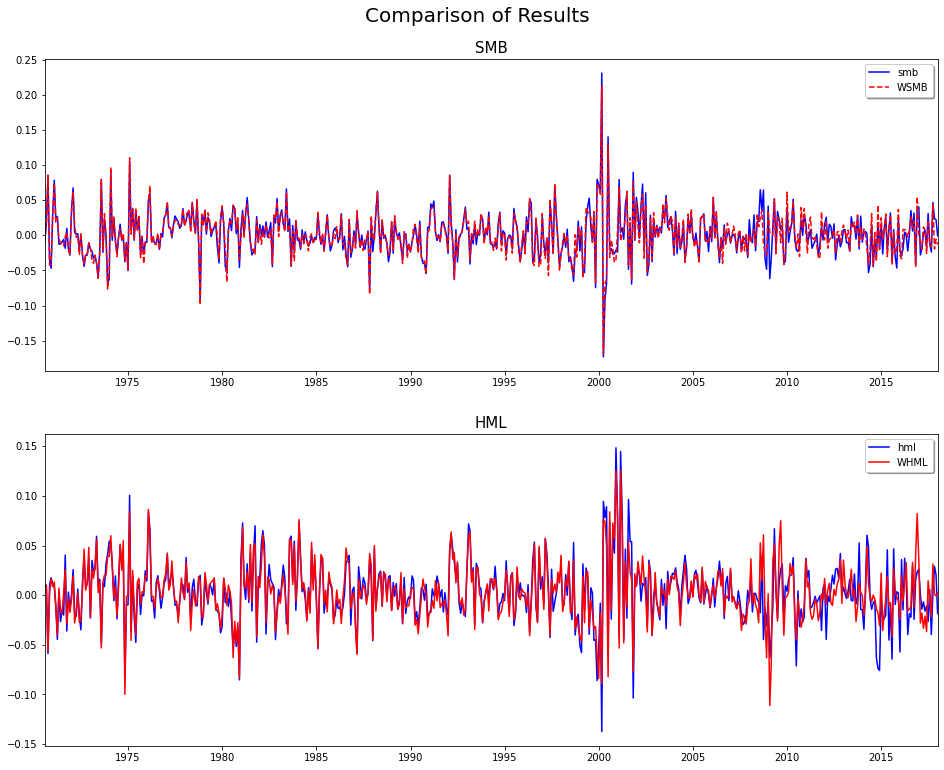

In [91]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Results', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('SMB', fontsize=15)
ax1.set_xlim(_ffcomp['date'].min(), _ffcomp['date'].max())
ax1.plot(_ffcomp['date'], _ffcomp['WSMB'], 'b-')
ax1.plot(_ffcomp['date'], _ffcomp['smb'], 'r--')
ax1.legend(('smb','WSMB'), loc='upper right', shadow=True)

ax2 = plt.subplot(212)
ax2.set_title('HML', fontsize=15)
ax2.plot(_ffcomp['date'], _ffcomp['WHML'], 'b-')
ax2.plot(_ffcomp['date'], _ffcomp['hml'], 'r-')

ax2.set_xlim(_ffcomp['date'].min(), _ffcomp['date'].max())
ax2.legend(('hml','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [92]:
crsp_comp.head(1)

,date,permno,shrcd,exchcd,retadj,me,wt,cumretx,ffyear,jdate,szport,bmport,posbm,BE/ME Quantiles,ME Quantiles,nonmissport,vwret_quintiles,Rm
0,1988-07-29,10001,11,3,0.03,6386.0,6200.0,1.03,1988,1988-07-31,S,H,1.0,4.0,1.0,1.0,0.012445,-0.006728


### Panel A: Average Returns and Standard Deviations

In [93]:
temp = crsp_comp.groupby(['jdate', 'BE/ME Quantiles', 'ME Quantiles'])['vwret_quintiles'].sum().reset_index()
temp2 = crsp_comp.groupby(['BE/ME Quantiles', 'ME Quantiles'])['vwret_quintiles'].mean().reset_index()
temp2['vwret_quintiles'] *= 100
temp2 = temp2.loc[~((temp2['BE/ME Quantiles']==0) | (temp2['ME Quantiles']==0)), :]
temp2.pivot(index='ME Quantiles', columns='BE/ME Quantiles', values='vwret_quintiles')

BE/ME Quantiles,1.0,2.0,3.0,4.0,5.0
ME Quantiles,,,,,
1.0,0.452887,1.137139,1.328070,1.463346,1.541307
2.0,0.717028,1.151940,1.323032,1.439040,1.362472
3.0,0.699690,1.101526,1.213197,1.268595,1.428485
4.0,0.861497,1.108011,1.136032,1.145292,1.468427
5.0,0.520278,0.969581,1.078829,1.150271,1.243370


In [94]:
temp = crsp_comp.groupby(['jdate', 'BE/ME Quantiles', 'ME Quantiles'])['vwret_quintiles'].sum().reset_index()
temp2 = crsp_comp.groupby(['BE/ME Quantiles', 'ME Quantiles'])['vwret_quintiles'].std().reset_index()
temp2['vwret_quintiles'] *= 100
temp2 = temp2.loc[~((temp2['BE/ME Quantiles']==0) | (temp2['ME Quantiles']==0)), :]
temp2.pivot(index='ME Quantiles', columns='BE/ME Quantiles', values='vwret_quintiles')

BE/ME Quantiles,1.0,2.0,3.0,4.0,5.0
ME Quantiles,,,,,
1.0,7.841927,7.131264,6.158681,5.695073,6.163667
2.0,7.749136,6.221799,5.644858,5.584240,6.233580
3.0,7.137101,5.904949,5.352008,5.178967,5.939745
4.0,6.603966,5.430512,5.179360,4.745672,5.451757
5.0,5.410451,5.008216,4.558064,4.766312,5.378736


In [95]:
# vwret['year'] = vwret.jdate.dt.year
# vwret['month'] = vwret.jdate.dt.month
# temp = vwret[vwret['szport']=='S']
# temp = temp.groupby(['year', 'month'])['vwret_labels'].sum().reset_index()
# temp.groupby('year')['vwret_labels'].mean()

### Panel B: Regressions

In [189]:
crsp_comp.drop(columns=['TCMNOM_Y1_x', 'TCMNOM_Y1_y'], inplace=True)

In [190]:
# ADD TREASURY RATES IN
# TCMNOM_Y1: Treasury constant maturity 1 month
rates = pd.read_csv('../data/frb_rates.csv', usecols=['date', 'TCMNOM_Y1'],infer_datetime_format= True, parse_dates=['date'])
rates = rates[(rates['date']>='1963-01-01') & (rates['date']<='1993-12-31')]

rates['month'] = rates.date.dt.month
rates['year'] = rates.date.dt.year
rates['date'] = rates['date'] + MonthEnd(0)
rates['TCMNOM_Y1'] /= 100 # convert from percentages to decimal
rates['TCMNOM_Y1'] /= 12 # convert to monthly 
rates = rates.groupby(['date'])['TCMNOM_Y1'].mean().reset_index()

crsp_comp = crsp_comp.merge(rates, how='left', left_on='jdate', right_on='date')
crsp_comp.drop(columns=['date_x', 'date_y'], inplace=True)

crsp_comp['Rm - Rf'] = crsp_comp['Rm'] - crsp_comp['TCMNOM_Y1']

crsp_comp.head(3)

,permno,shrcd,exchcd,retadj,me,wt,cumretx,ffyear,jdate,szport,bmport,posbm,BE/ME Quantiles,ME Quantiles,nonmissport,vwret_quintiles,Rm,Rm - Rf,TCMNOM_Y1
0,10001,11,3,0.030000,6386.00,6200.000000,1.03,1988,1988-07-31,S,H,1.0,4.0,1.0,1.0,0.012445,-0.006728,-0.013190,0.006462
1,10001,11,3,0.029126,6572.00,6385.999996,1.06,1988,1988-08-31,S,H,1.0,4.0,1.0,1.0,-0.007292,-0.023778,-0.030587,0.006809
2,10001,11,3,-0.021132,6362.25,6571.999997,1.02,1988,1988-09-30,S,H,1.0,4.0,1.0,1.0,0.016561,0.035110,0.028366,0.006744


In [191]:
ri_minus_rf = crsp_comp.groupby(['BE/ME Quantiles', 'ME Quantiles', 'jdate'])['vwret_quintiles'].sum().reset_index()
ri_minus_rf = ri_minus_rf[(ri_minus_rf['BE/ME Quantiles']!=0) & (ri_minus_rf['ME Quantiles']!=0)]
ri_minus_rf.head(3)

,BE/ME Quantiles,ME Quantiles,jdate,vwret_quintiles
109,1.0,1.0,1970-07-31,7.265977
110,1.0,1.0,1970-08-31,7.829094
111,1.0,1.0,1970-09-30,29.756620


In [202]:
# Create temp DF to hold Rm - Rf
temp = crsp_comp.drop_duplicates('jdate')

# Create Df that holds only data needed for the regressions
regressions = ri_minus_rf
regressions = regressions.merge(ff_factors[['date','WHML', 'WSMB']], how='left', left_on='jdate', right_on='date')
regressions = regressions.merge(temp[['jdate','Rm - Rf']], how='left', on='jdate')

regressions['vwret_quintiles'] /= 100
regressions.head()

,BE/ME Quantiles,ME Quantiles,jdate,vwret_quintiles,date,WHML,WSMB,Rm - Rf
0,1.0,1.0,1970-07-31,0.072660,1970-07-31,0.010936,-0.010005,0.078043
1,1.0,1.0,1970-08-31,0.078291,1970-08-31,0.005465,0.018496,0.045166
2,1.0,1.0,1970-09-30,0.297566,1970-09-30,-0.058828,0.085204,0.031001
3,1.0,1.0,1970-10-31,-0.150164,1970-10-31,0.010310,-0.035239,-0.029988
4,1.0,1.0,1970-11-30,-0.046612,1970-11-30,0.017513,-0.046898,0.052593


In [203]:
import statsmodels.api as sm

temp = regressions.loc[(regressions['BE/ME Quantiles']==1) & (regressions['ME Quantiles']==1), :]
temp = temp[temp['date']<='1993-12-31']
X = temp[['WHML', 'WSMB', 'Rm - Rf']]
y = temp['vwret_quintiles']
X = sm.add_constant(X)

In [204]:
df_cols = ['BE/ME Quantiles', 'ME Quantiles', 'alpha coeff', 'HML coeff', 'SMB coeff',\
                      'Rm - Rf coeff', 'alpha tvalue', 'HML tvalue', 'SMB tvalue', 'Rm - Rf tvalue', 'rsquared']

results = pd.DataFrame(columns=df_cols)

for i in range(1, 5):
    for j in range(1, 5):
        temp = regressions.loc[(regressions['BE/ME Quantiles']==i) & (regressions['ME Quantiles']==j), :]
        temp = temp[temp['date']<='1993-12-31']
        X = temp[['WHML', 'WSMB', 'Rm - Rf']]
        y = temp['vwret_quintiles']
        X = sm.add_constant(X)
        
        est = sm.OLS(y, X).fit()
        alpha_coeff, hml_coeff, smb_coeff, rm_rf_coeff = est.params # save coefficients
        alpha_tvalue, hml_tvalue, smb_tvalue, rm_rf_tvalue = est.tvalues # save t-values
        rsquared = est.rsquared
        temp_results = pd.DataFrame(columns= df_cols, data = [[i,j, alpha_coeff, hml_coeff, smb_coeff, rm_rf_coeff,\
                                   alpha_tvalue, hml_tvalue, smb_tvalue, rm_rf_tvalue, rsquared]])
        results = results.append(temp_results)

In [205]:
results.pivot(index='ME Quantiles', columns='BE/ME Quantiles', values='alpha coeff')

BE/ME Quantiles,1,2,3,4
ME Quantiles,,,,
1,0.011913,0.022993,0.019362,0.024626
2,0.011389,0.006720,0.007340,0.006529
3,0.007926,0.004627,0.004625,0.004184
4,0.005949,0.003361,0.002994,0.003268


In [210]:
results.pivot(index='ME Quantiles', columns='BE/ME Quantiles', values='Rm - Rf coeff')

BE/ME Quantiles,1,2,3,4
ME Quantiles,,,,
1,5.594455,3.165552,2.688995,2.807417
2,1.542574,0.970129,0.838860,0.754081
3,1.229619,0.788932,0.703241,0.543726
4,0.923699,0.659441,0.536080,0.436669


In [211]:
results.pivot(index='ME Quantiles', columns='BE/ME Quantiles', values='SMB coeff')

BE/ME Quantiles,1,2,3,4
ME Quantiles,,,,
1,5.126993,3.394843,2.807088,3.370979
2,1.084265,0.792371,0.663717,0.596416
3,0.686271,0.473365,0.396157,0.305462
4,0.259288,0.208542,0.124829,0.084495


In [212]:
results.pivot(index='ME Quantiles', columns='BE/ME Quantiles', values='HML coeff')

BE/ME Quantiles,1,2,3,4
ME Quantiles,,,,
1,-2.882026,-0.237646,0.472778,1.161207
2,-1.007903,-0.083947,0.128331,0.398532
3,-0.582117,0.082112,0.222040,0.248974
4,-0.441304,0.074403,0.151105,0.127154


In [213]:
results.pivot(index='ME Quantiles', columns='BE/ME Quantiles', values='rsquared')

BE/ME Quantiles,1,2,3,4
ME Quantiles,,,,
1,0.757853,0.877000,0.907963,0.904020
2,0.883978,0.915113,0.891674,0.889367
3,0.913010,0.895238,0.921438,0.900673
4,0.897128,0.894027,0.897111,0.813753


## Appendix 

### Compustat Definitions:  
**Table Name:**  
Compustat Fundamentals Annual - comp.funda  

- **PSTKRV:** Preferred Stock Redemption Value	
    - This item represents the total dollar value of the net number of preferred shares outstanding multiplied by the voluntary liquidation or redemption value per share?whichever is greater.
- **PSTKL:**  Preferred Stock Liquidating Value
PSTK -- Preferred/Preference Stock (Capital) - Total
    - This item represents the net number of preferred shares at year-end multiplied by the par or stated value per share as presented in the company's Balance Sheet.
- **SEQ:**  Stockholders' Equity - Total	
    - This item represents the common and preferred shareholders' interest in the company.
- **TXDITC:**  Deferred Taxes and Investment Tax Credit	
    - This item represents the accumulated tax deferrals due to timing differences between the reporting of revenues and expenses for financial statements and tax forms and investment tax credit.

### CRSP Definitions:
**Table Name:**  
CRSP Monthly Stock File - crsp.msf  

- **shrcd:** Share Code  
    - Security type code (SHRCD) has two digits, with each digit representing a specific piece of information. The first defines the security type; the second provides more detailed information about the type of security traded. For example, a SHRCD of 10 or 11 would represent U.S. common stocks.  
- **exchd:** Exchange Code  
    - EXCHCD is a code indicating the exchange on which a security is listed. Normal exchange codes are respectively 1,2, and 3 for NYSE, AMEX and the Nasdaq Stock MarketSM. An exchange code of zero indicates that a security is either trading on an unknown exchange, or is temporarily not trading at all. 
- **ret:** Holding Period Return  
    - A return is the change in the total value of an investment in a common stock over some period of time per dollar of initial investment. RET(I) is the return for a sale on day I. It is based on a purchase on the most recent time previous to I when the se curity had a valid price. Usually, this time is I - 1.  
- **retx:** Holding Period Return without Dividends  
    - RETX contains returns without dividends. Ordinary dividends and certain other regularly taxable dividends are excluded from the returns calculation. The formula is the same as for RET except d(t) is usually 0.  
- **shrout**: Number of Shares Outstanding  
    - SHROUT is the number of publicly held shares, recorded in thousands  
- **prc:** Price 
    - Prc is the closing price or the negative bid/ask average for a trading day. If the closing price is not available on any given trading day, the number in the price field has a negative sign to indicate that it is a bid/ask average and not an actual closing price. Please note that in this field the negative sign is a symbol and that the value of the bid/ask average is not negative.


**Table Name:**  
CRSP Delisting Return - crsp.msedelist 

- **dlstdt:** Delist Date  
- **dlret:** Delisting Return
    - DLRET is the return of the security after it is delisted. It is calculated by comparing a value after delisting against the price on the security's last trading date. The value after delisting can include a delisting price or the amount from a final distribution. If NEXTDT is nonzero, it can be used as the effective date of DLRET  

### Linking Table
**Table Name:**  
CRSP Compustat Linking Table - crsp.ccmxpf_linktable

- **Linktype:**   
    - LINKTYPE is the link type code describing the connection between CRSP and Compustat data. Special attention should be paid to this variable to avoid double counting caused by multiple links.  
- **Linkprim:**  
    - LINKPRIM clarifies the link's relationship to Compustat's marked primary security within the related range. "P" indicates a primary link marker, as identified by Compustat in monthly security data. "C" indicates a primary link marker, as identified by CRSP to resolve ranges of overlapping or missing primary markers from Compustat in order to produce one primary security throughout the company history. "J" indicates a joiner secondary issue of a company, identified by Compustat in monthly security data.  
- **Linkdt:**  
    - LINKDT is a calendar date marking the first effective date of the current link. If the link was valid before CRSP's earliest record, LINKDT is set to be SAS missing code ".B".  
- **Linkenddt:**  
    -LINKENDDT is the last effective date of the link record. It uses the SAS missing code ".E" if a link is still valid.  
- **Lpermno:**  
    - LPERMNO is missing if no link exists for a given GVKEY. It is up to the user to decide on how to handle overlaps and soft links.  